<h1><center> MELANOMA DETECTION </center></h1>

<h3> Problem Statement </h3><br>

Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of  skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant. The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

The notebook was run on Google Colab. Thus, data was uploaded to Google Drive.<br> The following code is used to access the folder where the training and test dataset is stored. <br>
**Note** : This code needs to be run everytime the notebook is loaded onto Colab.

In [1]:
## Uncomment this to connect to drive.

# importing required modules for working with drive
# from google.colab import drive

# common functions for mounting and using google drive
# drive.mount('/content/gdrive')

# # # datapath of the data folder
# datasetPath = '/content/gdrive/MyDrive/Melanoma/'


Mounted at /content/gdrive


### Importing the different libraries

In [2]:
# importing libraries
import pathlib
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import PIL
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img

from glob import glob

Custom Functions: <br>

In [3]:

# Function to plot accuracy and loss info epoch wise
def get_accuracy_info(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Melanoma/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Melanoma/Test')

In [5]:
# Setting global parameters
batch_size = 32
img_height = 180
img_width = 180
seed = 123
epochs = 20

In [6]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Visualization of data

Found 2239 files belonging to 9 classes.


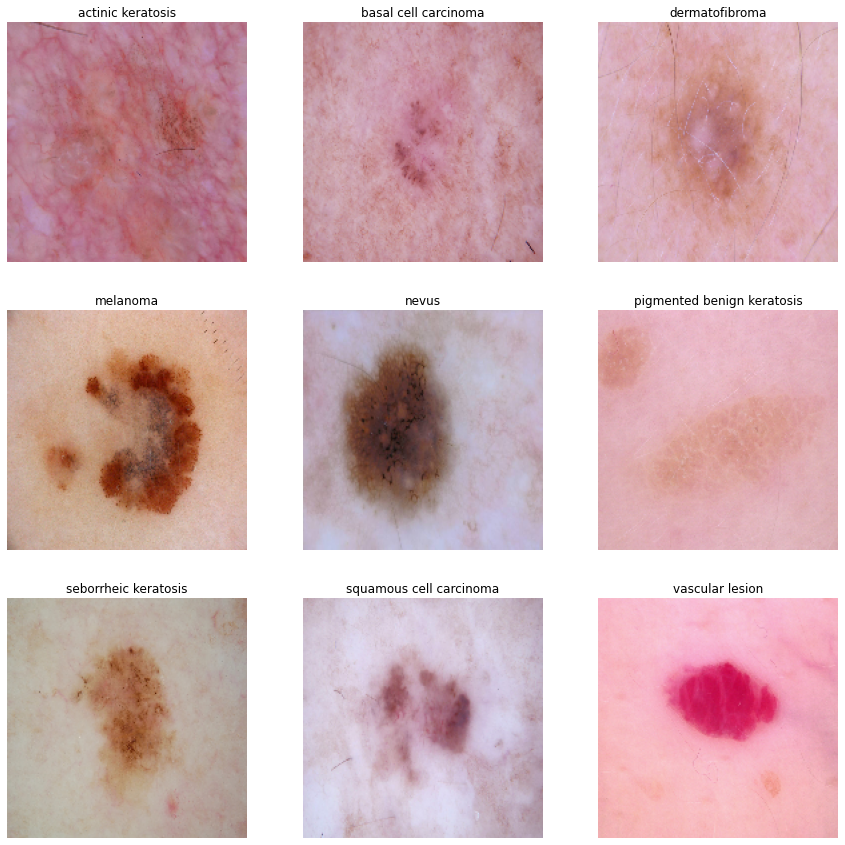

In [7]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

### Data Distribution

In [23]:
# method to find class distribution in training dataset
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #percentage of data
    percentage = [round((i/sum(count))*100, 2) for i in count]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count, percentage)),columns =['Class', 'No. of Image', 'Percentage of total dataset'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image,Percentage of total dataset
0,nevus,357,15.94
1,seborrheic keratosis,77,3.44
2,basal cell carcinoma,376,16.79
3,pigmented benign keratosis,462,20.63
4,squamous cell carcinoma,181,8.08
5,actinic keratosis,114,5.09
6,dermatofibroma,95,4.24
7,melanoma,438,19.56
8,vascular lesion,139,6.21


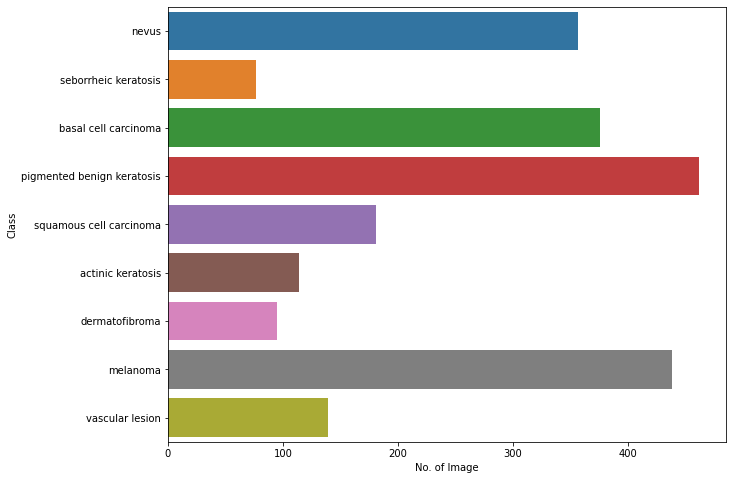

In [9]:
#Visualize the Number of image in each class.

plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### Conclusion: <br>
From the above bar chart, it is quite clear that the dataset is highly imbalanced. <br>
Thus it is imperative that we need to treat the imbalance. We will be using Augmentor library for this purpose.

In [10]:
# Creating train and validation data from data in the training folder
"""
Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.
"""

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size, image_size=(img_height, img_width), seed=seed, label_mode = "categorical", validation_split=0.2, subset='training')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size, image_size=(img_height, img_width), seed=seed, label_mode = "categorical", validation_split=0.2, subset='validation')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# Different classes in the dataset
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [12]:
# rescaling train and validation data to lie between [0, 1] using layers.experimental.preprocessing.Rescaling
rescaling_layer = layers.experimental.preprocessing.Rescaling(1./225)

normalized_train_ds = train_ds.map(lambda x, y: (rescaling_layer(x), y))

normalized_val_ds = val_ds.map(lambda x, y: (rescaling_layer(x), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


 <h2> Model Creation</h2>

### Model 1

In [13]:
model = Sequential()

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# flatten and put a fully connected layer
model.add(layers.Flatten())
# fully connected
model.add(layers.Dense(128, activation='relu')) 

# softmax layer
model.add(layers.Dense(len(class_names), activation='softmax'))

# we are using the optimizer as Adam and loss function and categorical crossentropy, also the metrics we are using for compilation is accuracy for compiling the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model summary
display(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)      0

None

In [14]:
# fitting the model built above on scaled - training and validation dataset
history1 = model.fit(
  normalized_train_ds,
  validation_data=normalized_val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 656s 10s/step - loss: 2.0494 - accuracy: 0.2589 - val_loss: 1.8090 - val_accuracy: 0.3020
Epoch 2/20
56/56 [==============================] - 18s 299ms/step - loss: 1.7001 - accuracy: 0.3806 - val_loss: 1.6988 - val_accuracy: 0.3669
Epoch 3/20
56/56 [==============================] - 16s 255ms/step - loss: 1.6095 - accuracy: 0.4241 - val_loss: 1.5613 - val_accuracy: 0.4787
Epoch 4/20
56/56 [==============================] - 17s 266ms/step - loss: 1.4389 - accuracy: 0.4933 - val_loss: 1.3991 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 17s 254ms/step - loss: 1.3685 - accuracy: 0.5206 - val_loss: 1.4440 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 16s 258ms/step - loss: 1.3235 - accuracy: 0.5335 - val_loss: 1.4406 - val_accuracy: 0.4989
Epoch 7/20
56/56 [==============================] - 18s 300ms/step - loss: 1.2343 - accuracy: 0.5619 - val_loss: 1.4230 - val_accuracy: 0.5078


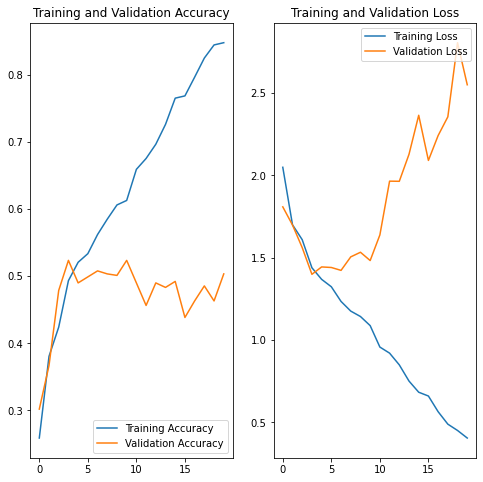

In [15]:
# visualising the result of fitting this model
get_accuracy_info(history1, epochs)

---

Observations: <br>
1. It can be seen that even though training accuracy is high, validation accuracy is quite poor.
2. It can be seen that validation loss is also increasing whereas training loss is decreasing. This means the although model is able to understand the data, it is not able to generalize it.
3. This is a clear sign of overfitting of data.

### Model 2

For this attempt, I will be using augmentation technique to populate the data in a way to handle class imbalance.

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [17]:
dataGenerator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                            rotation_range=90,
                                                            width_shift_range=0.2,
                                                            height_shift_range=0.2,
                                                            horizontal_flip=True,
                                                            vertical_flip=True,
                                                            zoom_range=0.2,
                                                            validation_split=0.2)

#augmenting training data
train_ds_aug = dataGenerator.flow_from_directory(directory=data_dir_train,
                                            target_size=(img_height, img_width),
                                            color_mode='rgb',
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            subset='training',
                                            seed=seed,
                                            )

#augmenting testing data
val_ds_aug = dataGenerator.flow_from_directory(directory=data_dir_train,
                                            target_size=(img_height, img_width),
                                            color_mode='rgb',
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            subset='validation',
                                            seed=seed,
                                            )

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


Build the model:

Train the model on augmented data

This model will be using **dropouts**. This should lead to improvements in the metrics.

In [19]:
model_final = Sequential()
model_final.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model_final.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_final.add(layers.Dropout(0.25))

model_final.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_final.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_final.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_final.add(layers.MaxPooling2D(pool_size=(2, 2)))

# flatten and put a fully connected layer
model_final.add(layers.Flatten())

# fully connected
model_final.add(layers.Dense(128, activation='relu')) 
model_final.add(layers.Dropout(0.5))

# softmax layer
model_final.add(layers.Dense(len(class_names), activation='softmax'))

# model summary
model_final.summary()

model_final.compile(optimizer='Adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

In [20]:
history_drop_aug = model_final.fit(
  train_ds_aug,
  validation_data=val_ds_aug,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 58s 983ms/step - loss: 2.2604 - accuracy: 0.1922 - val_loss: 2.0359 - val_accuracy: 0.2703
Epoch 2/20
57/57 [==============================] - 54s 955ms/step - loss: 1.9607 - accuracy: 0.2869 - val_loss: 1.8896 - val_accuracy: 0.2928
Epoch 3/20
57/57 [==============================] - 54s 944ms/step - loss: 1.8185 - accuracy: 0.3276 - val_loss: 1.7952 - val_accuracy: 0.2950
Epoch 4/20
57/57 [==============================] - 55s 971ms/step - loss: 1.9227 - accuracy: 0.2741 - val_loss: 1.7183 - val_accuracy: 0.3626
Epoch 5/20
57/57 [==============================] - 54s 952ms/step - loss: 1.7849 - accuracy: 0.3493 - val_loss: 1.7341 - val_accuracy: 0.3153
Epoch 6/20
57/57 [==============================] - 54s 950ms/step - loss: 1.7115 - accuracy: 0.3783 - val_loss: 1.8188 - val_accuracy: 0.3086
Epoch 7/20
57/57 [==============================] - 55s 966ms/step - loss: 1.6619 - accuracy: 0.3989 - val_loss: 1.7227 - val_accuracy: 0.3468

Visualizing the metrics:

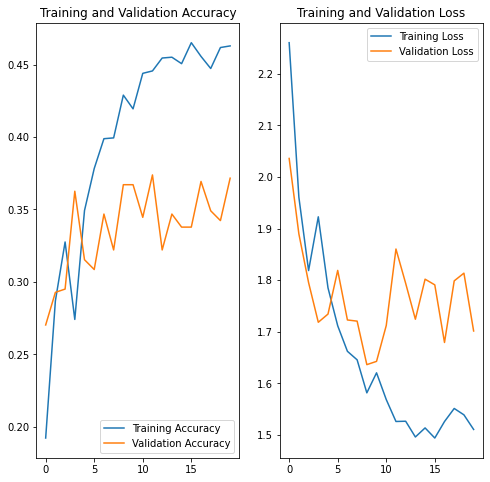

In [21]:
get_accuracy_info(history_drop_aug, epochs)

### Observation:
1. The model has slightly improved, although overfitting exists.
2. The training accuracy might be lower, but the model is able to generalize better as can be seen from the loss charts.

### Rectification of model due to class imbalance

Due to class imbalance, we will be using Augmentor to recify the problem.

In [26]:
# !pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import Augmentor

In [28]:
path_to_training_dataset = str(data_dir_train)

In [29]:
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset +'/' + i, output_directory='/content/output/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/output/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD370E689A0>: 100%|██████████| 1000/1000 [00:37<00:00, 26.71 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/output/basal cell carcinoma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD370E267C0>: 100%|██████████| 1000/1000 [00:37<00:00, 26.99 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/output/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD370F13B50>: 100%|██████████| 1000/1000 [00:38<00:00, 25.82 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/output/melanoma.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7FD370F44790>: 100%|██████████| 1000/1000 [03:21<00:00,  4.97 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/output/nevus.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FD370DD6A90>: 100%|██████████| 1000/1000 [02:47<00:00,  5.96 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/output/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD3926EBA30>: 100%|██████████| 1000/1000 [00:35<00:00, 28.12 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/output/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD370E49700>: 100%|██████████| 1000/1000 [01:28<00:00, 11.28 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/output/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD3903ED970>: 100%|██████████| 1000/1000 [00:36<00:00, 27.72 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/output/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD370EDDAC0>: 100%|██████████| 1000/1000 [00:37<00:00, 26.72 Samples/s]


In [30]:
image_count_train = len(list(pathlib.Path('/content/output').glob('*/*.jpg')))
print(image_count_train)

9000


In [37]:
path_list = [x for x in glob(os.path.join('/content/output/*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob('/content/output/*/*.jpg')]
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

# Checking number of images after this augmentation
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2['Label'].value_counts()

actinic keratosis             1000
melanoma                      1000
basal cell carcinoma          1000
dermatofibroma                1000
squamous cell carcinoma       1000
pigmented benign keratosis    1000
nevus                         1000
vascular lesion               1000
seborrheic keratosis          1000
Name: Label, dtype: int64

## Training models on the augmented dataset:

In [35]:
batch_size = 32
img_height = 180
img_width = 180

In [36]:
# Loading the data in variables
aug_dir_to_train = pathlib.Path('/content/output')

aug_train_ds = tf.keras.preprocessing.image_dataset_from_directory(aug_dir_to_train, batch_size=batch_size, image_size=(img_height, img_width), seed=seed, label_mode = "categorical", validation_split=0.2, subset='training')
aug_val_ds = tf.keras.preprocessing.image_dataset_from_directory(aug_dir_to_train, batch_size=batch_size, image_size=(img_height, img_width), seed=seed, label_mode = "categorical", validation_split=0.2, subset='validation')

Found 9000 files belonging to 9 classes.
Using 7200 files for training.
Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [38]:
# Caching the data
AUTOTUNE = tf.data.experimental.AUTOTUNE
aug_train_ds = aug_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
aug_val_ds = aug_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [39]:
# rescaling train and validation data to lie between [0, 1], normalization
rescaling_layer = layers.experimental.preprocessing.Rescaling(1./225)
normalized_aug_train_ds = aug_train_ds.map(lambda x, y: (rescaling_layer(x), y))

normalized_aug_val_ds = aug_val_ds.map(lambda x, y: (rescaling_layer(x), y))

In [40]:
model_final = Sequential()
model_final.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model_final.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_final.add(layers.Dropout(0.25))

model_final.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_final.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_final.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_final.add(layers.MaxPooling2D(pool_size=(2, 2)))

# flatten and put a fully connected layer
model_final.add(layers.Flatten())
# fully connected
model_final.add(layers.Dense(128, activation='relu')) 
model_final.add(layers.Dropout(0.5))

# softmax layer
model_final.add(layers.Dense(len(class_names), activation='softmax'))

# model summary
model_final.summary()

model_final.compile(optimizer='Adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 41, 41, 128)      

In [42]:
history_final = model_final.fit(
  normalized_aug_train_ds,
  validation_data=normalized_aug_val_ds,
  epochs=30
)

Epoch 1/30
225/225 [==============================] - 41s 91ms/step - loss: 1.9429 - accuracy: 0.2758 - val_loss: 1.6002 - val_accuracy: 0.3906
Epoch 2/30
225/225 [==============================] - 13s 57ms/step - loss: 1.5401 - accuracy: 0.3971 - val_loss: 1.5620 - val_accuracy: 0.3928
Epoch 3/30
225/225 [==============================] - 13s 57ms/step - loss: 1.4218 - accuracy: 0.4603 - val_loss: 1.2811 - val_accuracy: 0.5322
Epoch 4/30
225/225 [==============================] - 13s 56ms/step - loss: 1.3370 - accuracy: 0.4914 - val_loss: 1.3192 - val_accuracy: 0.5328
Epoch 5/30
225/225 [==============================] - 13s 58ms/step - loss: 1.2449 - accuracy: 0.5228 - val_loss: 1.1207 - val_accuracy: 0.6128
Epoch 6/30
225/225 [==============================] - 13s 59ms/step - loss: 1.1343 - accuracy: 0.5718 - val_loss: 1.0349 - val_accuracy: 0.6578
Epoch 7/30
225/225 [==============================] - 13s 59ms/step - loss: 1.0809 - accuracy: 0.5964 - val_loss: 0.9660 - val_accuracy:

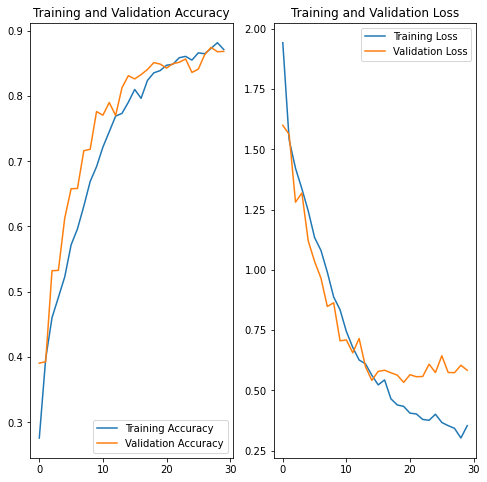

In [43]:
get_accuracy_info(history_final, 30)

## Observations: <br>
1. The accuracy has greatly improved after augmentation.
2. Both the training and validation losses has reduced signficantly. 

This model is ideal for making predictions.

---

## Model prediction

1/1 [==============================] - 0s 23ms/step
Actual Class: basal cell carcinoma 
Predictive Class: basal cell carcinoma


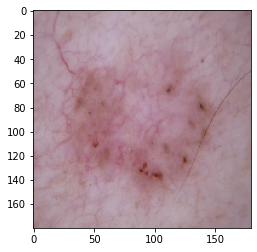

In [46]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[1]} \nPredictive Class: {pred_class}")

---